이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 한국어 스팀 리뷰 감성 분석 튜토리얼입니다.  
이 자료는 2021년 10월 9일에 마지막으로 테스트되었습니다.

링크 : https://wikidocs.net/94748

# 1. BiLSTM을 텍스트 분류에 사용하기

케라스에서는 양방향 LSTM을 사용하면서 return_sequences=False를 택할 경우에는 아래의 링크와 같이 동작합니다.  

https://wikidocs.net/images/page/94748/bilstm3.PNG

# 2. Colab에 Mecab 설치

In [2]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91
Receiving objects: 100% (138/138), 1.72 MiB | 4.40 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 45.2 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-11-07 05:53:52--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response.

In [3]:
# 아래 실행 후 메뉴에서 "런타임" -> "런타임 다시 시작" 선택
!pip install mecab

  Using cached mecab-0.996.3.tar.gz (62 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for mecab: filename=mecab-0.996.3-cp310-cp310-linux_x86_64.whl size=167498 sha256=e2ea63f7e8bb72c1ef34f3b8b623cd8c88d3f484b3ab6e9886d3f757e73d067f
  Stored in directory: /root/.cache/pip/wheels/10/1a/b2/8c0e17d02a12c7b46e3065f55aa7555d173a5b020110717829
Successfully built mecab


# 3. 스팀 리뷰 데이터에 대한 이해와 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7a5785814820>)

In [3]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


In [4]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [5]:
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

In [6]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


In [7]:
print(total_data.isnull().values.any())

False


In [8]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


<Axes: >

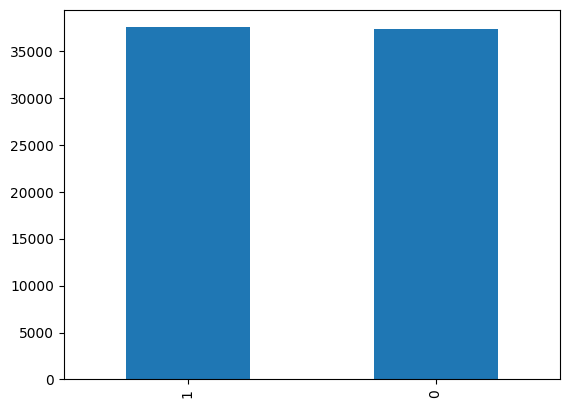

In [9]:
train_data['label'].value_counts().plot(kind = 'bar')

In [10]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  37376
1      1  37543


In [11]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


<ipython-input-11-5c91c21161d5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [12]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 24973


<ipython-input-12-5968a3f5f2bc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [13]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [14]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [15]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [16]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [17]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


In [18]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


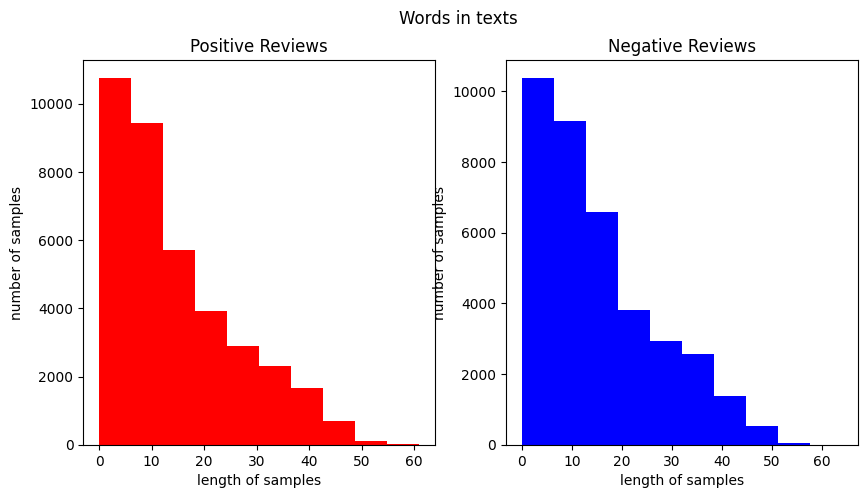

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [20]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [22]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 희귀 단어의 수: 13878
단어 집합에서 희귀 단어의 비율: 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2254607619437832


In [23]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18941


In [24]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
print(X_train[:3])

[[495, 7, 35, 87, 149, 2429, 599, 26, 8, 70, 47, 235, 111, 38, 44, 52], [161, 300, 18, 20, 63, 3582, 985, 6, 56], [7, 17, 1476, 4]]


In [26]:
print(X_test[:3])

[[728, 34, 16, 431, 52, 106, 132, 99, 6461, 453], [4527, 687, 835, 712, 792, 108, 4, 1779, 95, 370, 3519, 81, 558, 1904, 4189, 262, 169, 61, 25, 363, 35, 87, 974, 19, 6294, 6422], [1792, 806, 685, 49, 23, 349]]


리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


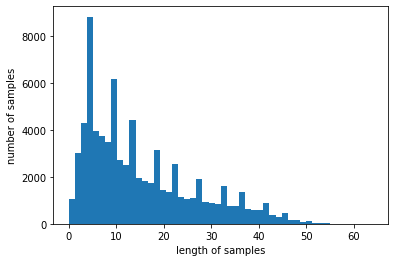

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [28]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


In [29]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 4. BiLSTM으로 스팀 리뷰 감성 분류하기

In [ ]:
import re

In [30]:
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(GRU(100)))
model.add(Dense(1, activation='sigmoid'))

In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [33]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.5696 - acc: 0.6941
Epoch 1: val_acc improved from -inf to 0.76101, saving model to best_model.h5
235/235 [==============================] - 29s 88ms/step - loss: 0.5696 - acc: 0.6941 - val_loss: 0.4982 - val_acc: 0.7610
Epoch 2/15
  3/235 [..............................] - ETA: 14s - loss: 0.4743 - acc: 0.7799

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


235/235 [==============================] - ETA: 0s - loss: 0.4699 - acc: 0.7794
Epoch 2: val_acc improved from 0.76101 to 0.77770, saving model to best_model.h5
235/235 [==============================] - 11s 45ms/step - loss: 0.4699 - acc: 0.7794 - val_loss: 0.4713 - val_acc: 0.7777
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.4389 - acc: 0.8007
Epoch 3: val_acc did not improve from 0.77770
235/235 [==============================] - 6s 24ms/step - loss: 0.4389 - acc: 0.8007 - val_loss: 0.5328 - val_acc: 0.7600
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.4197 - acc: 0.8134
Epoch 4: val_acc did not improve from 0.77770
235/235 [==============================] - 5s 22ms/step - loss: 0.4197 - acc: 0.8134 - val_loss: 0.4861 - val_acc: 0.7696
Epoch 5/15
235/235 [==============================] - ETA: 0s - loss: 0.4021 - acc: 0.8223
Epoch 5: val_acc did not improve from 0.77770
235/235 [==============================] - 5s 20ms/step - los

In [34]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 6s 7ms/step - loss: 0.4822 - acc: 0.7828
테스트 정확도: 0.7828


# 5. 리뷰 예측해보기

In [37]:
import re
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [38]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

1/1 [==============================] - 1s 746ms/step
92.26% 확률로 부정 리뷰입니다.


In [39]:
sentiment_predict('유일하게 어벤져스 시리즈중에 엔딩 안본 게임이다. 돈버린 느낌')

1/1 [==============================] - 0s 27ms/step
62.65% 확률로 긍정 리뷰입니다.


In [40]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

1/1 [==============================] - 0s 21ms/step
98.03% 확률로 긍정 리뷰입니다.


In [41]:
sentiment_predict('케릭터가 예뻐서 좋아요')

1/1 [==============================] - 0s 21ms/step
86.11% 확률로 긍정 리뷰입니다.
